In [50]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 23 06:55:11 2025

@author: josgomezru modified from dariograna

Reference: Grana and de Figueiredo, 2021, SeReMpy - Equations 5 and 6
           Li and Liu, 2019, Equations 6 and 7
"""

# Geostatistical Petrophysical inversion Driver %%
# In this script we apply the Ensenmble petrophysical inversion method
# (Liu and Grana, 2018) to predict the petrophysical properties 
# from seismic data.

'\nCreated on Sun Feb 23 06:55:11 2025\n\n@author: josgomezru modified from dariograna\n\nReference: Grana and de Figueiredo, 2021, SeReMpy - Equations 5 and 6\n           Li and Liu, 2019, Equations 6 and 7\n'

In [51]:
#Load library
import sys
sys.path.append('/workspaces/SeReMpy/Applications')
sys.path.append('/workspaces/SeReMpy/Data')

In [52]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from numpy import matlib

#from context import SeReMpy
#from SeReMpy.Inversion import *

In [53]:
# Función para la aproximación AVA relacionada con los factores Q
def ava_approximation(theta, vp, vs, rho, qp, qs, freq, freq_ref):
    a_theta = 0.5 * (1 + np.tan(np.radians(theta))**2)
    b_theta = -4 * (vs/vp)**2 * np.sin(np.radians(theta))**2
    c_theta = 0.5 * (1 - 4 * (vs/vp)**2 * np.sin(np.radians(theta))**2)
    d_theta = 0.5 * (1 + np.tan(np.radians(theta))**2) * (1/np.pi) * np.log(freq_ref/freq)
    e_theta = -4 * (vs/vp)**2 * np.sin(np.radians(theta))**2 * (1/np.pi) * np.log(freq_ref/freq)
    
    r_pp = a_theta * vp + b_theta * vs + c_theta * rho + d_theta * qp + e_theta * qs
    return r_pp

# Función de inversión para los factores Q
def invert_q_factors(seismic_data, theta, vp, vs, rho, freq, freq_ref):
    # Inicializar los factores Q
    qp = 10.76 * vp**2 #np.ones_like(vp) * 100  # Suposición inicial para Qp
    qs = 10.76 * vs**2 #np.ones_like(vs) * 50   # Suposición inicial para Qs
    
    # Proceso iterativo de inversión
    for iteration in range(10):  # Número de iteraciones
        r_pp = ava_approximation(theta, vp, vs, rho, qp, qs, freq, freq_ref)
        r_pp = np.tile(r_pp, (seismic_data.shape[0] // r_pp.shape[0], 1))  # Ajustar dimensiones
        residuals = seismic_data[:r_pp.shape[0], :] - r_pp
        
        # Actualizar los factores Q basados en los residuos
        qp += 0.1 * residuals[:, 0]
        qs += 0.05 * residuals[:, 0]
    
    return qp, qs

In [54]:
# Cargar datos (seismic data and time)
x = np.loadtxt('/workspaces/SeReMpy/Data/1Ddatalog.dat')
Rho = x[:,4].reshape(-1, 1)
Time = x[:,6].reshape(-1, 1)
Vp = x[:,7].reshape(-1, 1)
Vs = x[:,8].reshape(-1, 1)
s= np.loadtxt('/workspaces/SeReMpy/Data/1Ddataseis.dat')
Sfar = s[:,0].reshape(-1, 1)
Smid = s[:,1].reshape(-1, 1)
Snear = s[:,2].reshape(-1, 1)
TimeSeis = s[:,3].reshape(-1, 1)

In [56]:
# Parámetros iniciales
theta = np.linspace(15, 45, 3)
freq = 45
freq_ref = 25

In [57]:
# Inversión de factores Q
seismic_data = np.hstack([Snear, Smid, Sfar])
qp_inverted, qs_inverted = invert_q_factors(seismic_data, theta, Vp, Vs, Rho, freq, freq_ref)

ValueError: non-broadcastable output operand with shape (99,1) doesn't match the broadcast shape (99,0)

NameError: name 'qp_inverted' is not defined

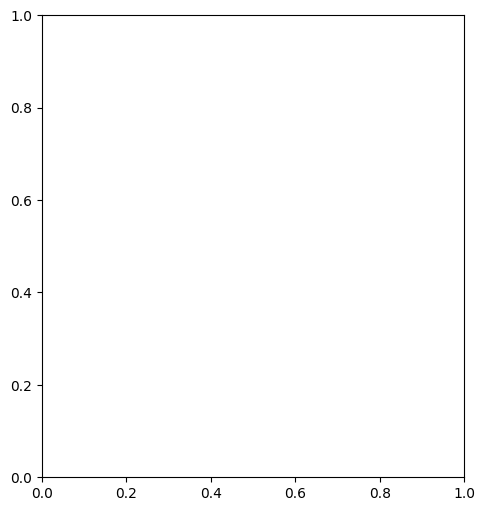

In [45]:
# Graficar resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(qp_inverted, Time, 'r', label='Qp Invertido')
plt.xlabel('Qp')
plt.ylabel('Time (s)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(qs_inverted, Time, 'b', label='Qs Invertido')
plt.xlabel('Qs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()